# Исследование спектра интегрального оператора

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.size']=18

import scipy as sp

# Функция трехмерной структурированной сетки центров ячеек

In [8]:
def make_grid(N, L, center, **kwargs):
    """
    :param N: список из трех элементов [n_3, n_2, n_1] целых чисел, числа ячеек 
    дискретизации объемной области решения системой прямоугольных параллелепипедов
    :param L: список из трех элементов [l_3, l_2, l_1] вещественных чисел, длины
    дисркетизируемой объемной области решения по каждой из направления декартовой сетки координат
    :param center: список трех элементов [с_3, с_2, с_1] вещественных чисел расположения центра
    объемной области решения в трехмерной системы координат для вариации расположения области решения
    
    :return: (grid, volume), где grid - сетка в трехмерной системе координат с узловыми точками
    прямоугольных ячеек, volume - объем разбиения (прямоугольного параллелепипеда)
     """
    
    # Границы сетки
    x = np.linspace(-L[0]/2 - center[0], L[0]/2 - center[0], N[0] + 1)
    y = np.linspace(-L[1]/2 - center[1], L[1]/2 - center[1], N[1] + 1)
    z = np.linspace(-L[2]/2 - center[2], L[2]/2 - center[2], N[2] + 1)
    
    # Объем ячейки
    h_x = x[1] - x[0]
    h_y = y[1] - y[0]
    h_z = z[1] - z[0]
    volume = h_x * h_y * h_z
    
    # Середины - точки коллокации
    x = (x[1:] + x[:-1])/2
    y = (y[1:] + y[:-1])/2
    z = (z[1:] + z[:-1])/2
    
    # Сетка - трехмерный тензор, вытянутый в строку размером n_3*n_2*n_1
    grid = np.array(np.meshgrid(x, y, z, indexing='ij')).T.reshape(-1, 3)
    
    return grid, volume

# Функция определения матрицы диэлектрической проницаемости среды

In [9]:
def step_dielectric(grid,
                       eps_real,
                       eps_imag,
                       x1_bounds,
                       x2_bounds,
                       x3_bounds):
    """
    grid - Тензор (n_1, n_2, n_3, 3) для каждой точки пространства
    eps_real
    """
    if eps_real is None:
        eps_real = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
    if eps_imag is None:
        eps_imag = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
    if x1_bounds is None:
        x1_bounds = [-1.0, 0.5]
    if x2_bounds is None:
        x2_bounds = [-1.0, 1.0]
    if x3_bounds is None:
        x3_bounds = [-1.0, 1.0]

    eps = np.zeros((grid.shape[0], 3, 3)) + 0.0j
    indexes = ((grid[:, 0] >= x1_bounds[0]) * (grid[:, 0] <= x1_bounds[1]) *
               (grid[:, 1] >= x2_bounds[0]) * (grid[:, 1] <= x2_bounds[1]) *
               (grid[:, 2] >= x3_bounds[0]) * (grid[:, 2] <= x3_bounds[1]))
    eps[indexes] = np.array(eps_real) + 1j * np.array(eps_imag)
    return eps, indexes


def ellipsis_dielectric(grid,
                           eps_real,
                           eps_imag,
                           center,
                           radius):
    if eps_real is None:
        eps_real = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
    if eps_imag is None:
        eps_imag = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
    if center is None:
        center = [0.0, 0.0, 0.0]
    if radius is None:
        radius = [1.0, 1.0, 1.0]
    eps = np.zeros((grid.shape[0], 3, 3)) + 0j
    indexes = (
        ((grid[:, 0] - center[0]) ** 2) / (radius[0] ** 2) +
        ((grid[:, 1] - center[1]) ** 2) / (radius[1] ** 2) +
        ((grid[:, 2] - center[2]) ** 2) / (radius[2] ** 2)
    ) <= 1
    eps[indexes] = np.array(eps_real) + 1j * np.array(eps_imag)
    return eps, indexes


def apply_dielectric(grid,
                        eps_vec=None, **kwargs):
    if eps_vec is None:
        eps_vec = [
            {
                "type": "step",
                "eps_real": [[1.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0],
                             [0.0, 0.0, 1.0]],
                "eps_imag": [[0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0]],
                "x1_bounds": [-1.0, 0.0],
                "x2_bounds": [-1.0, 1.0],
                "x3_bounds": [-1.0, 1.0]
            },
            {
                "type": "ellipsis",
                "eps_real": [[1.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0],
                             [0.0, 0.0, 1.0]],
                "eps_imag": [[1.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0],
                             [0.0, 0.0, 1.0]],
                "center": [0.0, 0.0, 0.0],
                "radius": [1.0, 1.0, 1.0]
            }
        ]

    eps = np.zeros((grid.shape[0], 3, 3)) + 0j
    indexes = np.zeros(grid.shape[0], dtype=bool)
    for num, element in enumerate(eps_vec):
        if element.get("type") == "step":
            eps_d, indexes_d = step_dielectric(grid=grid,
                                                  eps_real=element.get('eps_real'),
                                                  eps_imag=element.get('eps_imag'),
                                                  x1_bounds=element.get('x1_bounds'),
                                                  x2_bounds=element.get('x2_bounds'),
                                                  x3_bounds=element.get('x3_bounds'))
        elif element.get("type") == "ellipsis":
            eps_d, indexes_d = ellipsis_dielectric(grid=grid,
                                                      eps_real=element.get('eps_real'),
                                                      eps_imag=element.get('eps_imag'),
                                                      center=element.get('center'),
                                                      radius=element.get('radius'))
        else:
            continue
        indexes += indexes_d
        eps += eps_d
    return eps, indexes

# Функция Грина

In [10]:
def kernel(x, k=1):
    return np.exp(1j * k * x)/(4 * np.pi * x)

In [11]:
# Функция расчета коэффицентов-матриц дисркетного оператора B
def b_coeff(x, y, k, dv):
    diff = x - y
    R = np.sqrt(np.sum(diff * diff))
    alpha_n = diff / R
    alpha_nm = alpha_n[np.newaxis, :] * alpha_n[:, np.newaxis]
    delta = np.eye(3)
    gr = kernel(R, k)
    coef_1 = ((3/R) * (1/R) - (3 * 1.0j * k) / (R) - (k*k)) * alpha_nm
    coef_2 = ((k*k) + (1.0j * k) / R  - (1/R * 1/R)) * delta
    return gr * dv * (coef_1 + coef_2)


# Заполнение оператора B с матрицами диэлектрической проницаемости среды
def B_eta_operator_matrix(grid, eta, k, volume):
    # Расчет коэффициентов тензора B
    B_matrix = np.zeros((grid.shape[0], grid.shape[0], 3, 3)) + 0.0j
    for i in range(grid.shape[0]-1):
        for j in range(i+1, grid.shape[0]):
            B_matrix[i, j] = b_coeff(grid[i], grid[j], k, volume) @ eta[j]
            B_matrix[j, i] = b_coeff(grid[j], grid[i], k, volume) @ eta[i]

    for i in range(grid.shape[0]):
        B_matrix[i, i] = (-1/3) * np.eye(3) @ eta[i]
    return B_matrix


# Заполнение оператора B без матриц диэлектрической проницаемости среды
def B_operator_matrix(grid, k, volume):
    # Расчет коэффициентов тензора B
    B_matrix = np.zeros((grid.shape[0], grid.shape[0], 3, 3)) + 0.0j
    for i in range(grid.shape[0]-1):
        for j in range(i+1, grid.shape[0]):
            B_matrix[i, j] = b_coeff(grid[i], grid[j], k, volume)
            B_matrix[j, i] = b_coeff(grid[j], grid[i], k, volume)

    for i in range(grid.shape[0]):
        B_matrix[i, i] = (-1/3) * np.eye(3)
    return B_matrix

# Программа для определения формы и положения спектра оператора

In [12]:
# Вспомогательная подфункция для программы определения выпуклой оболочки спектра оператора
def cross(o, a, b):
    """
    Возвращает векторное произведение OA и OB
    Положительное значение означает поворот против часовой стрелки
    """
    return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])


# Алгоритм последовательной цепи Эндрю для определения выпуклой оболочки множества точек спектра оператора на комплексной плоскости
def sequential_chain(points):
    """
    :points - список кортежей пар координат точек
    :Функция вычисляет минимальную выпуклую оболочку для заданного множества точек на плоскости
    методом последовательной цепи.
    :Возвращает список точек в порядке обхода оболочки.
    """

    # Сортируем точки лексикографически (по x, затем по y)
    points = sorted(set(points))
    if len(points) == 1:
        return points

    # Строим нижнюю оболочку
    lower = []
    for p in points:
        while len(lower) >= 2 and cross(lower[-2], lower[-1], p) <= 0:
            lower.pop()
        lower.append(p)

    # Строим верхнюю оболочку
    upper = []
    for p in reversed(points):
        while len(upper) >= 2 and cross(upper[-2], upper[-1], p) <= 0:
            upper.pop()
        upper.append(p)

    # Соединяем верхнюю и нижнюю оболочки
    # Последняя точка каждого списка совпадает с первой точкой другого списка, поэтому исключаем их
    convex = lower[:-1] + upper[:-1]
    return convex


def mu_2points(lambda_1, lambda_2):
    """
    :param lambda_1:
    :param lambda_2:
    :return mu: complex value of circle center on a complex plane
    """
    a = (lambda_1 + lambda_2) / 2
    numerator = 1j * (np.imag(lambda_1 * np.conj(lambda_2)) * (lambda_2 - lambda_1))
    denominator = 2 * (np.abs(lambda_1 * np.conj(lambda_2)) + np.real(lambda_1 * np.conj(lambda_2)))
    mu = a + numerator / denominator
    return mu


def radius_2points(lambda_1, lambda_2):
    """
    :param lambda_1:
    :param lambda_2:
    :return:
    """
    numerator = np.abs(lambda_1 - lambda_2) ** 2 * np.abs(np.conj(lambda_1) * lambda_2)
    denominator = 2 * (np.abs(np.conj(lambda_1) * lambda_2) + np.real(np.conj(lambda_1) * lambda_2))
    radius = np.sqrt(np.real(numerator / denominator))
    return radius


def mu_3points(lambda_1, lambda_2, lambda_3):
    """
    :param lambda_1:
    :param lambda_2:
    :param lambda_3:
    :return:
    """
    numerator = (np.abs(lambda_1) ** 2 * (lambda_2 - lambda_3)
                 +
                 np.abs(lambda_2) ** 2 * (lambda_3 - lambda_1)
                 +
                 np.abs(lambda_3) ** 2 * (lambda_1 - lambda_2))
    denominator = 2 * np.imag(lambda_1 * np.conj(lambda_2)
                              +
                              lambda_2 * np.conj(lambda_3)
                              +
                              lambda_3 * np.conj(lambda_1))
    return 1j * numerator / denominator


def radius_3points(mu, lambda_):
    """

    :param mu:
    :param lambda_:
    :return:
    """
    return abs(mu - lambda_).real


def compute_circle_two_points(lambda_1, lambda_2):
    """

    :param lambda_1:
    :param lambda_2:
    :return:
    """
    center = mu_2points(lambda_1, lambda_2)
    radius = radius_2points(lambda_1, lambda_2)
    return center, radius


def compute_circle_three_points(lambda_1, lambda_2, lambda_3):
    """

    :param lambda_1:
    :param lambda_2:
    :param lambda_3:
    :return:
    """
    x1, y1 = lambda_1.real, lambda_1.imag
    x2, y2 = lambda_2.real, lambda_2.imag
    x3, y3 = lambda_3.real, lambda_3.imag

    d = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))

    if np.abs(d) < 1e-12:
        return 1.0+0.0j, 0.0  # Points are colinear or too close

    center = mu_3points(lambda_1, lambda_2, lambda_3)
    radius = radius_3points(center, lambda_1)
    return center, radius


def circle_contains_points(center, radius, points, epsilon = 1e-8):
    """

    :param center:
    :param radius:
    :param points:
    :param epsilon:
    :return:
    """
    return np.prod(np.abs(points - center) <= radius + epsilon) > 0


def circle_contains_origin(center, radius, epsilon = 1e-8):
    """

    :param center:
    :param radius:
    :param epsilon:
    :return:
    """
    return abs(center) <= radius + epsilon


def circle_angle_from_origin(center, radius):
    """

    :param center:
    :param radius:
    :return:
    """
    d = abs(center)
    if d <= radius:
        return np.pi  # Origin is inside the circle
    ratio = radius / d
    ratio = max(-1.0, min(1.0, ratio))  # Clamp to [-1, 1] to avoid math domain error
    theta = 2 * np.arcsin(ratio)
    return theta


def find_params(points):
    """

    :param points:
    :return:
    """
    # Step 1:
    for point1, point2 in np.array(np.meshgrid(points, points)).T.reshape(-1, 2):
        center, radius = compute_circle_two_points(point1, point2)
        if circle_contains_points(center, radius, points):
            print(f"Circle center: {center}, radius: {radius}")
            print(f"Two points, point1: {point1}, point2: {point2}")
            return center, radius,

    # Step 2:
    best_theta = None
    best_circle = None
    for point1, point2, point3 in np.array(np.meshgrid(points, points, points)).T.reshape(-1, 3):
        center, radius = compute_circle_three_points(point1, point2, point3)
        if circle_contains_points(center, radius, points) and \
                not circle_contains_origin(center, radius):
            theta = circle_angle_from_origin(center, radius)
            if best_theta is None or theta < best_theta:
                best_theta = theta
                best_circle = (center, radius)

    if best_circle:
        center, radius = best_circle
        print(f"Circle center: {center}, radius: {radius}")
        return center, radius
    else:
        print("No circle found.")
        return 1.0 + 0.0j, 0.0

In [13]:
# Функция для распаковки тензора (N, N, m, m) -> (N*m, N*m)
def flatten_block_matrix(M4d):
    """
    Раскрывает 4D-блочную матрицу формы (N, N, m, m)
    в большую 2D-матрицу (N*m, N*m).
    """
    N, N2, m, m2 = M4d.shape
    assert N == N2 and m == m2, "Должно быть (N, N, m, m)."
    # Склеиваем оси (N, m) для строк, и (N, m) для столбцов
    return M4d.transpose(0,2,1,3).reshape(N*m, N*m)

In [499]:
# Конфиг задачи
problem_config = {
    'N': [10, 10, 10],
    'L': [1.0, 1.0, 1.0],
    'center': [0.0, 0.0, 0.0],
    'k': 5.0,
    'orient': [0.0, 1.0, 0.0],
    'amplitude': [1.0, 0.0, 0.0],
    'sign': 1.0,
    'eps_vec': [
        {
                "type": "step",
                "eps_real": [[1.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0],
                             [0.0, 0.0, 1.0]],
                "eps_imag": [[0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0]],
                "x1_bounds": [-1.0, 1.0],
                "x2_bounds": [-1.0, 1.0],
                "x3_bounds": [-1.0, 1.0]
            },
            {
                "type": "ellipsis",
                "eps_real": [[3.0, 0.0, 0.0],
                             [0.0, 2.0, 0.0],
                             [0.0, 0.0, 1.0]],
                "eps_imag": [[1.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0],
                             [0.0, 0.0, 1.0]],
                "center": [0.0, 0.0, 0.0],
                "radius": [0.5, 0.5, 0.5]
            }
    ]
}



# Размерность задачи
N = problem_config.get("N")

# Настройки быстрого умножения
n_1 = N[0]
n_2 = N[1]
n_3 = N[2]

to_reshape = tuple(N[::-1])
to_reshape_grid = tuple(N[::-1]+[3])
to_reshape_tensor = tuple(N[::-1]+[3, 3])

# Объем области Q
L = problem_config.get("L")

# Центр области Q
center = problem_config.get("center")

# Задание индекса eta(x) для точек внутри Q 
eps_vec = problem_config.get("eps_vec")

# Волновое число задачи
k=problem_config.get("k")

In [500]:
# Расчет сетки дискретизации
grid, volume = make_grid(N = N, L = L, center = center)
grid

# Расчет расстояний на сетке дискретизации
dists = np.linalg.norm(grid[0] - grid, axis=1)

# Ассоциация точкам сетки диэлектрической проницаемости
eta, ind = apply_dielectric(grid, eps_vec)
eta = eta - np.eye(3)[np.newaxis, :, :]

# Расчет блочной операторной матрицы B 
B_matrix = B_eta_operator_matrix(grid, eta, k, volume)

# Вычитаем единичную матрицу из B*eta
Bt = np.eye(np.prod(N) * 3) - flatten_block_matrix(B_matrix)

# Расчет собственных значений оператора встроенной программой
result_eigs = np.linalg.eigvals(Bt)

# Список собственных значений матричного оператора
print("Собственные значения матрицы оператора")
print(result_eigs[-10:])

Собственные значения матрицы оператора
[0.99790999+0.01257226j 0.9984709 +0.0148844j  0.99793475+0.01344644j
 0.99781959+0.0130918j  1.00726294+0.0207222j  1.00195526+0.01382094j
 1.00415307+0.01698787j 0.99932439+0.0162184j  0.99949702+0.01629991j
 1.10595841+0.08450135j]


In [501]:
# Поиск выпуклой оболочки спектрального множества
list_of_points = [(x.real, x.imag) for x in result_eigs]
hull = sequential_chain(list_of_points)
hull_eigs = np.array([x[0] + 1.0j * x[1] for x in hull])
print("\nВыпуклая оболочка спектра", hull_eigs)

# Центр и радиус для параметров итерационного метода
mu, radius = find_params(hull_eigs)
# Оценка сходимости
rho = np.arctan(radius/np.abs(mu))/2

print("\nЦентр окружности", mu)
print("Радиус окружности", radius)
print("Знаменатель сходимости", rho)


Выпуклая оболочка спектра [0.01206555-0.94486189j 0.62595483-2.71212124j 3.95760054-1.90152072j
 4.30482978+1.12426017j 3.20241756+1.11751302j 2.0997957 +1.1102481j
 0.42704673-0.26376443j]
Circle center: (3.2228755438116736-2.1186470957564487j), radius: 3.4186360625870416

Центр окружности (3.2228755438116736-2.1186470957564487j)
Радиус окружности 3.4186360625870416
Знаменатель сходимости 0.36261713104751003


In [502]:
# Краткая статистика по спектру
minRe = np.min(result_eigs.real) 
maxRe = np.max(result_eigs.real)
minIm = np.min(result_eigs.imag)
maxIm = np.max(result_eigs.imag)
print(r"Минимальное вещественное значение $min Re \sigma$=" + f"{minRe.round(4)}")
print(r"Максимальное вещественное значение $max Re \sigma$=" + f"{maxRe.round(4)}")
print(r"Минимальное мнимое значение $min Im \sigma$=" + f"{minIm.round(4)}")
print(r"Максимальное мнимое значение $min Im \sigma$=" + f"{maxIm.round(4)}")

Минимальное вещественное значение $min Re \sigma$=0.0121
Максимальное вещественное значение $max Re \sigma$=4.3048
Минимальное мнимое значение $min Im \sigma$=-2.7121
Максимальное мнимое значение $min Im \sigma$=1.1243


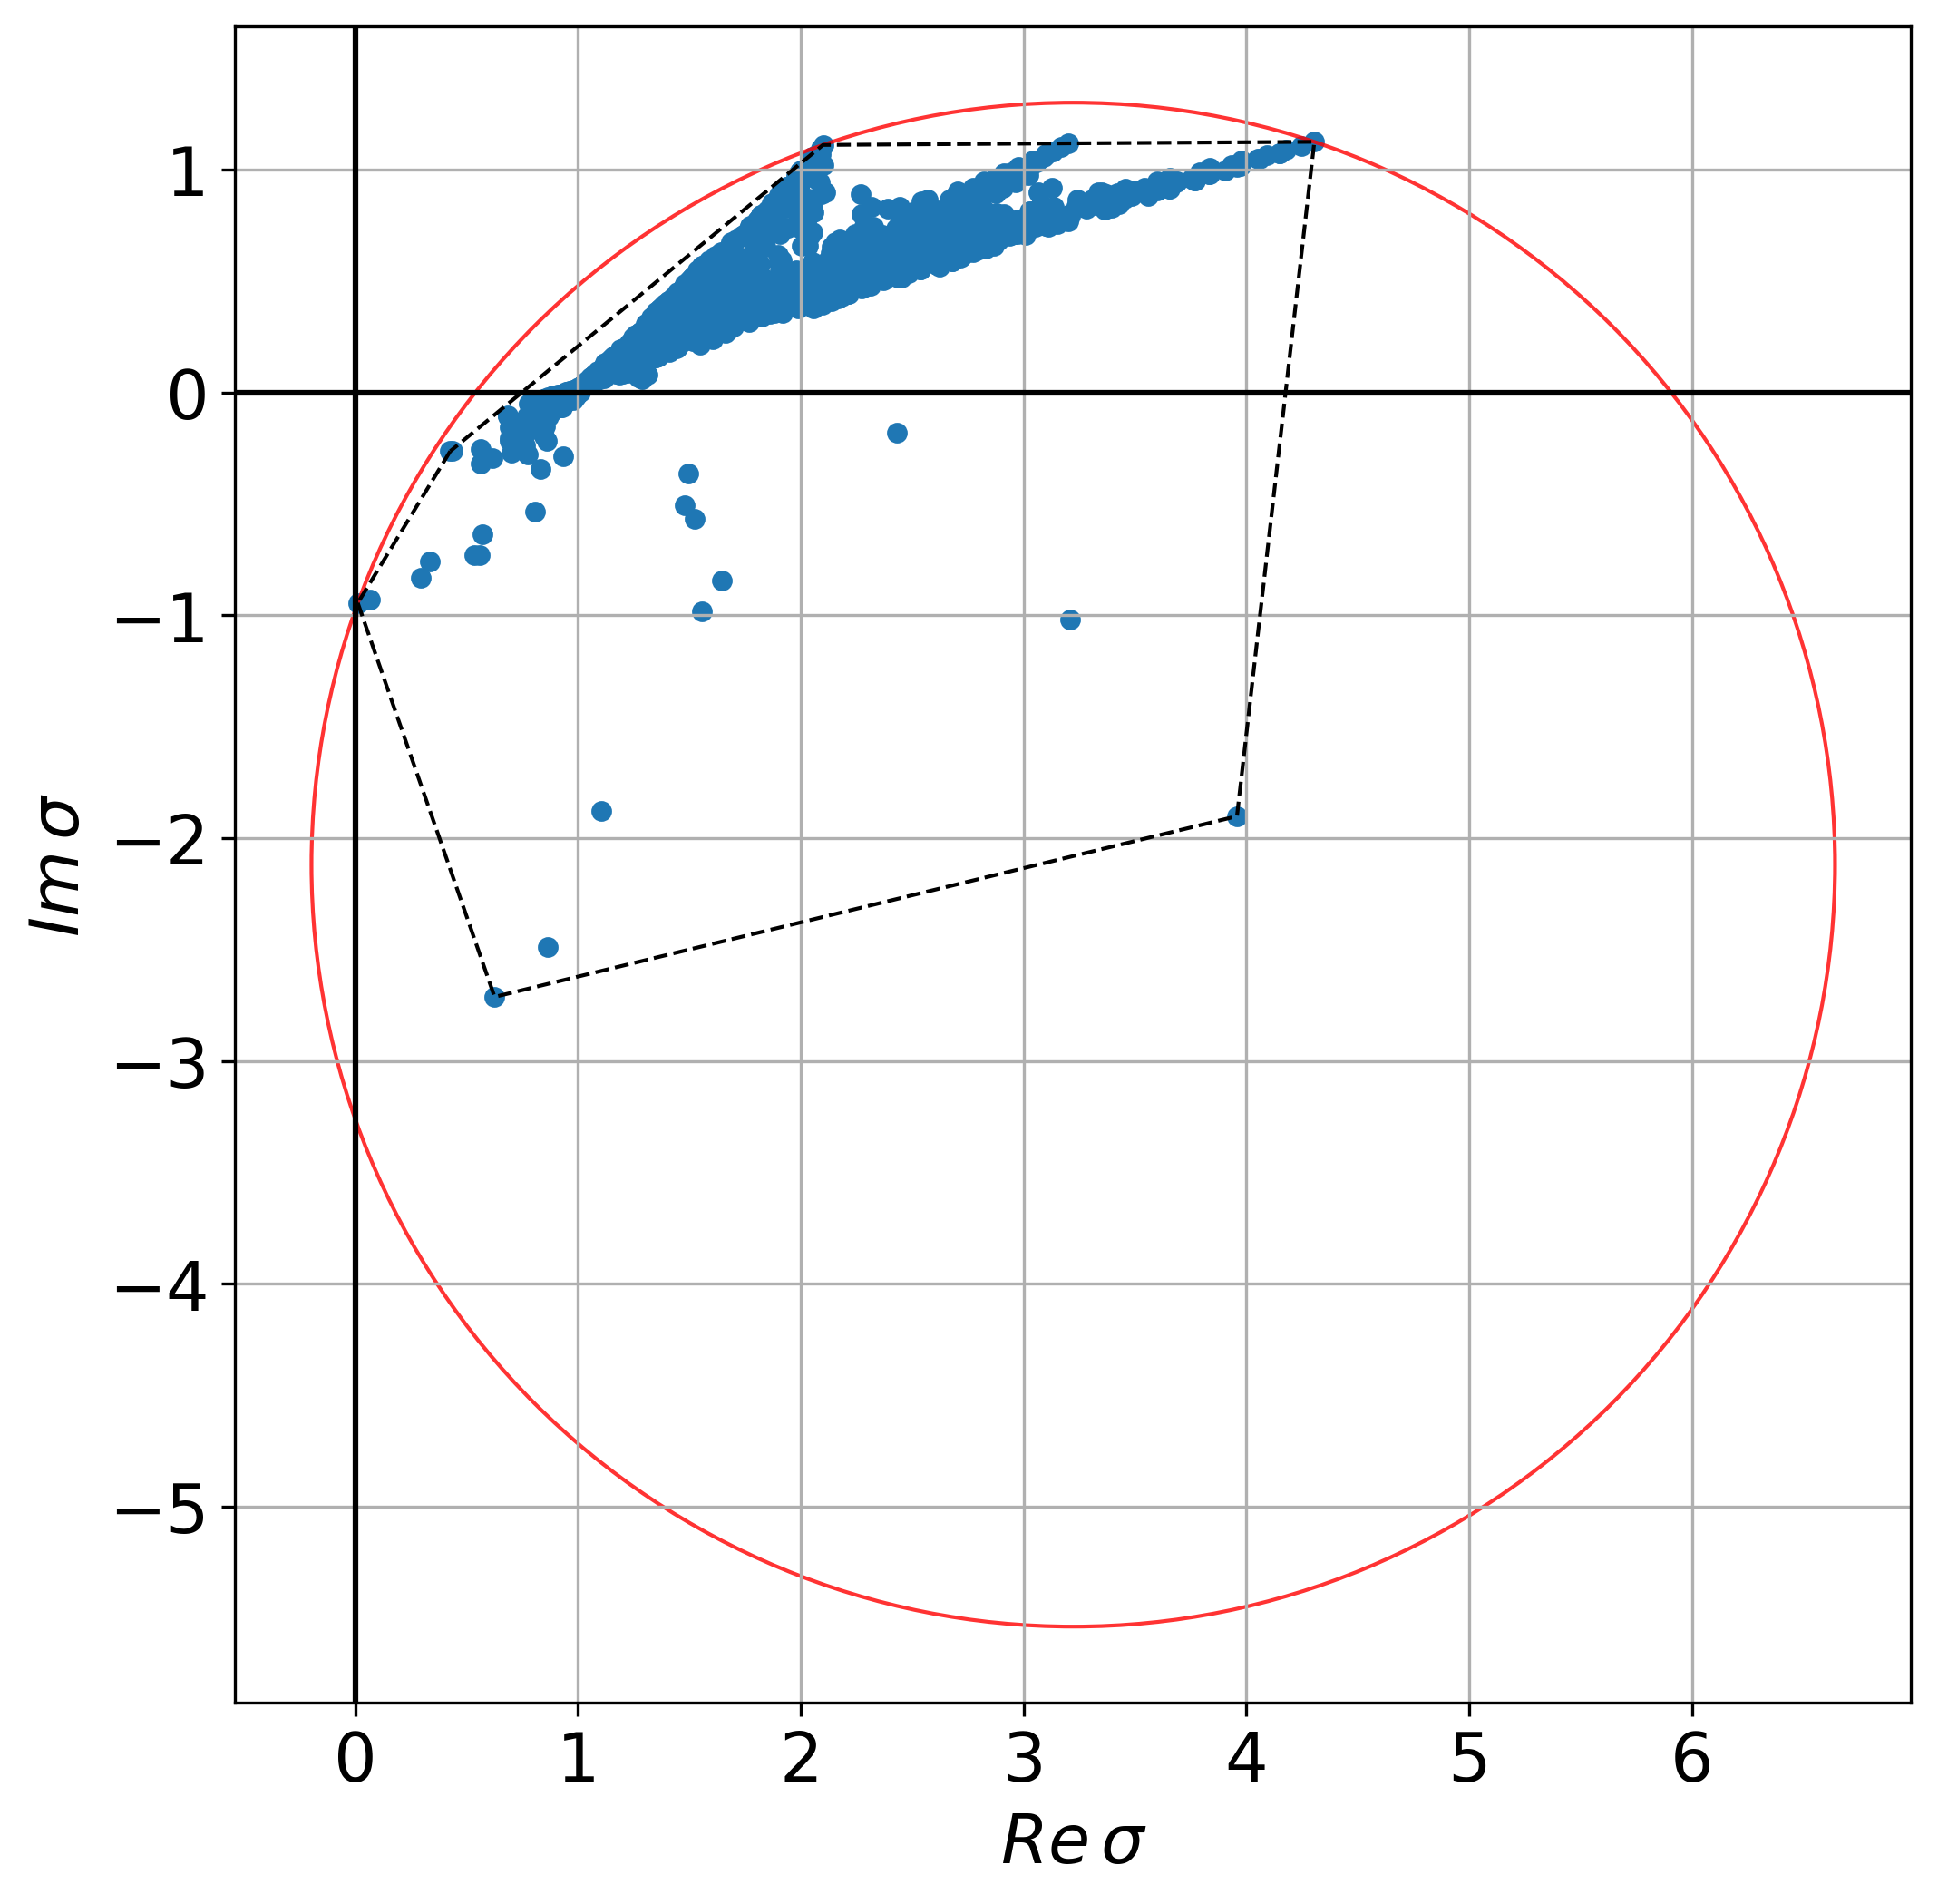

In [511]:
# Задание графика на холсте
plt.figure(figsize=(8,8), dpi=300)
plt.gca().set_aspect('equal')

# Визуализация спектра оператора на комплексной плоскости
plt.scatter(result_eigs.real, result_eigs.imag,s=20, label = r"$\sigma$")
#plt.xlim((-max(maxRe, maxIm)/4, max(maxRe, maxIm) + 1))   # Границы отрисовки
#plt.ylim((-max(maxRe, maxIm), max(maxRe, maxIm)))      # Границы отрисовки

# Визуализация выпуклой оболочки спектра
plt.plot(hull_eigs.real, hull_eigs.imag, c="black", linestyle="--", linewidth=1, label="hull")
plt.plot(hull_eigs.real[[-1, 0]], hull_eigs.imag[[-1, 0]], c="black", linestyle="--", linewidth=1)

circle1 = plt.Circle((mu.real, mu.imag), radius, color='r', fill=False, alpha=0.8, label="($\mu$, R)")
plt.gca().add_patch(circle1)

plt.axvline(0, color="black")
plt.axhline(0, color="black")

plt.xlabel(r"$Re\,\sigma$")
plt.ylabel(r"$Im\,\sigma$")

plt.grid()
#plt.legend()
plt.show()

# Реализация метода простой итерации для матрицы

In [512]:
# Функция расчета векторной нормы для комплекснозначных векторов
def complex_norm(f):
    return np.sqrt(np.sum(f * np.conj(f)).real)


# Расчет дискретизированного оператора в матричной форме
def operator_matrix(matrix, eta, vector):
    # Вычисление (eta * vector) поэлементно
    result = np.einsum("...ij,...j->...i", eta, vector)
    
    # Вычисление матрично-векторной операции B @ (eta * vector)
    result = np.einsum("ijkl,jl->ik", matrix, vector)
    
    # Вычитание vector - B @ (eta * vector)
    result = vector - result
    return result


# реализация метода простой итерации для матричной формы оператора
def SIM_matrix(matrix, vector_f, vector_eta, param_mu=None, u0=None, max_iter=100, tol=1e-8):
    # Списки для сохранения невязок и итераций
    resid_hist = []
    iters_hist = []
    delta_hist = []
    
    # Начальные значения с точки 0
    if u0 is None:
        u0 = np.zeros_like(vector_f) + 0.0j
        
    # Если mu не задан, устанавливаем значение 1
    if param_mu is None:
        param_mu = 1.0 + 0.0j
        
    # Подсчет нормы вектора свободных коэффициентов
    norm_f = complex_norm(vector_f)
    
    # Итерации метода
    for it in range(1 + max_iter + 1): # k=1,2,...,max_iter
        # Результат вычисления оператора с шагом приближения
        op_res = operator_matrix(matrix, vector_eta, u0)
        # подсчет невязки
        resid = op_res - vector_f
        # Следующее приближение по итерациям
        u1 = u0 - 1/(param_mu) * resid
        # Норма невязки
        resid_norm = complex_norm(resid)/norm_f
        # Вычисление дельты приближения
        delta = complex_norm(u1 - u0) / norm_f
        
        # Сохранение исторических значений итераций для графиков
        print(f"Итерация={it}, delta={delta}, resid={resid_norm}")
        resid_hist.append(resid_norm)
        iters_hist.append(it)
        delta_hist.append(delta)
        
        # остановка итераций
        if delta < tol:
            break
        # Копирование вектора
        u0 = np.copy(u1)
        
    return u1, iters_hist, delta_hist, resid_hist

In [513]:
def wave(x, k=1, orient=[0.0, 0.0, 1.0], sign=1, amplitude=[1.0, 0.0, 0.0], phi0=0.0, **kwargs):
    orient = np.array(orient) / np.linalg.norm(np.array(orient), 2)
    amplitude = np.array(amplitude)
    return amplitude.reshape(-1, 3) * np.exp(sign * 1j * k * (x.dot(orient)) - phi0).reshape(-1, 1)

f_wave = wave(grid, k, [1.0, 0.0, 0.0], 1, [0.0, 1.0, 0.0])

In [514]:
# Расчет коэффициентов тензора B
B_matrix = B_operator_matrix(grid, k, volume)

In [515]:
result_SIMm, iters_SIMm, delta_SIMm, resid_SIMm = SIM_matrix(B_matrix, f_wave, eta, mu)

Итерация=0, delta=0.259276327587718, resid=1.0
Итерация=1, delta=0.1765630185355017, resid=0.6809839532140363
Итерация=2, delta=0.13208393922291764, resid=0.5094330841994482
Итерация=3, delta=0.10540825298678642, resid=0.40654792501689097
Итерация=4, delta=0.08682822910668607, resid=0.3348868364286379
Итерация=5, delta=0.07237128532873945, resid=0.27912800988071274
Итерация=6, delta=0.06053370688794568, resid=0.23347178452867434
Итерация=7, delta=0.05069669055348983, resid=0.19553150503621738
Итерация=8, delta=0.04251447157729052, resid=0.16397359517099408
Итерация=9, delta=0.03572017611837353, resid=0.13776875216766074
Итерация=10, delta=0.030080152011045743, resid=0.11601580557279788
Итерация=11, delta=0.025390156285024362, resid=0.0979270129334673
Итерация=12, delta=0.021477560404188193, resid=0.08283656515815906
Итерация=13, delta=0.01820075832432588, resid=0.07019830346126846
Итерация=14, delta=0.015445679547835054, resid=0.059572270602334464
Итерация=15, delta=0.01312107699584286

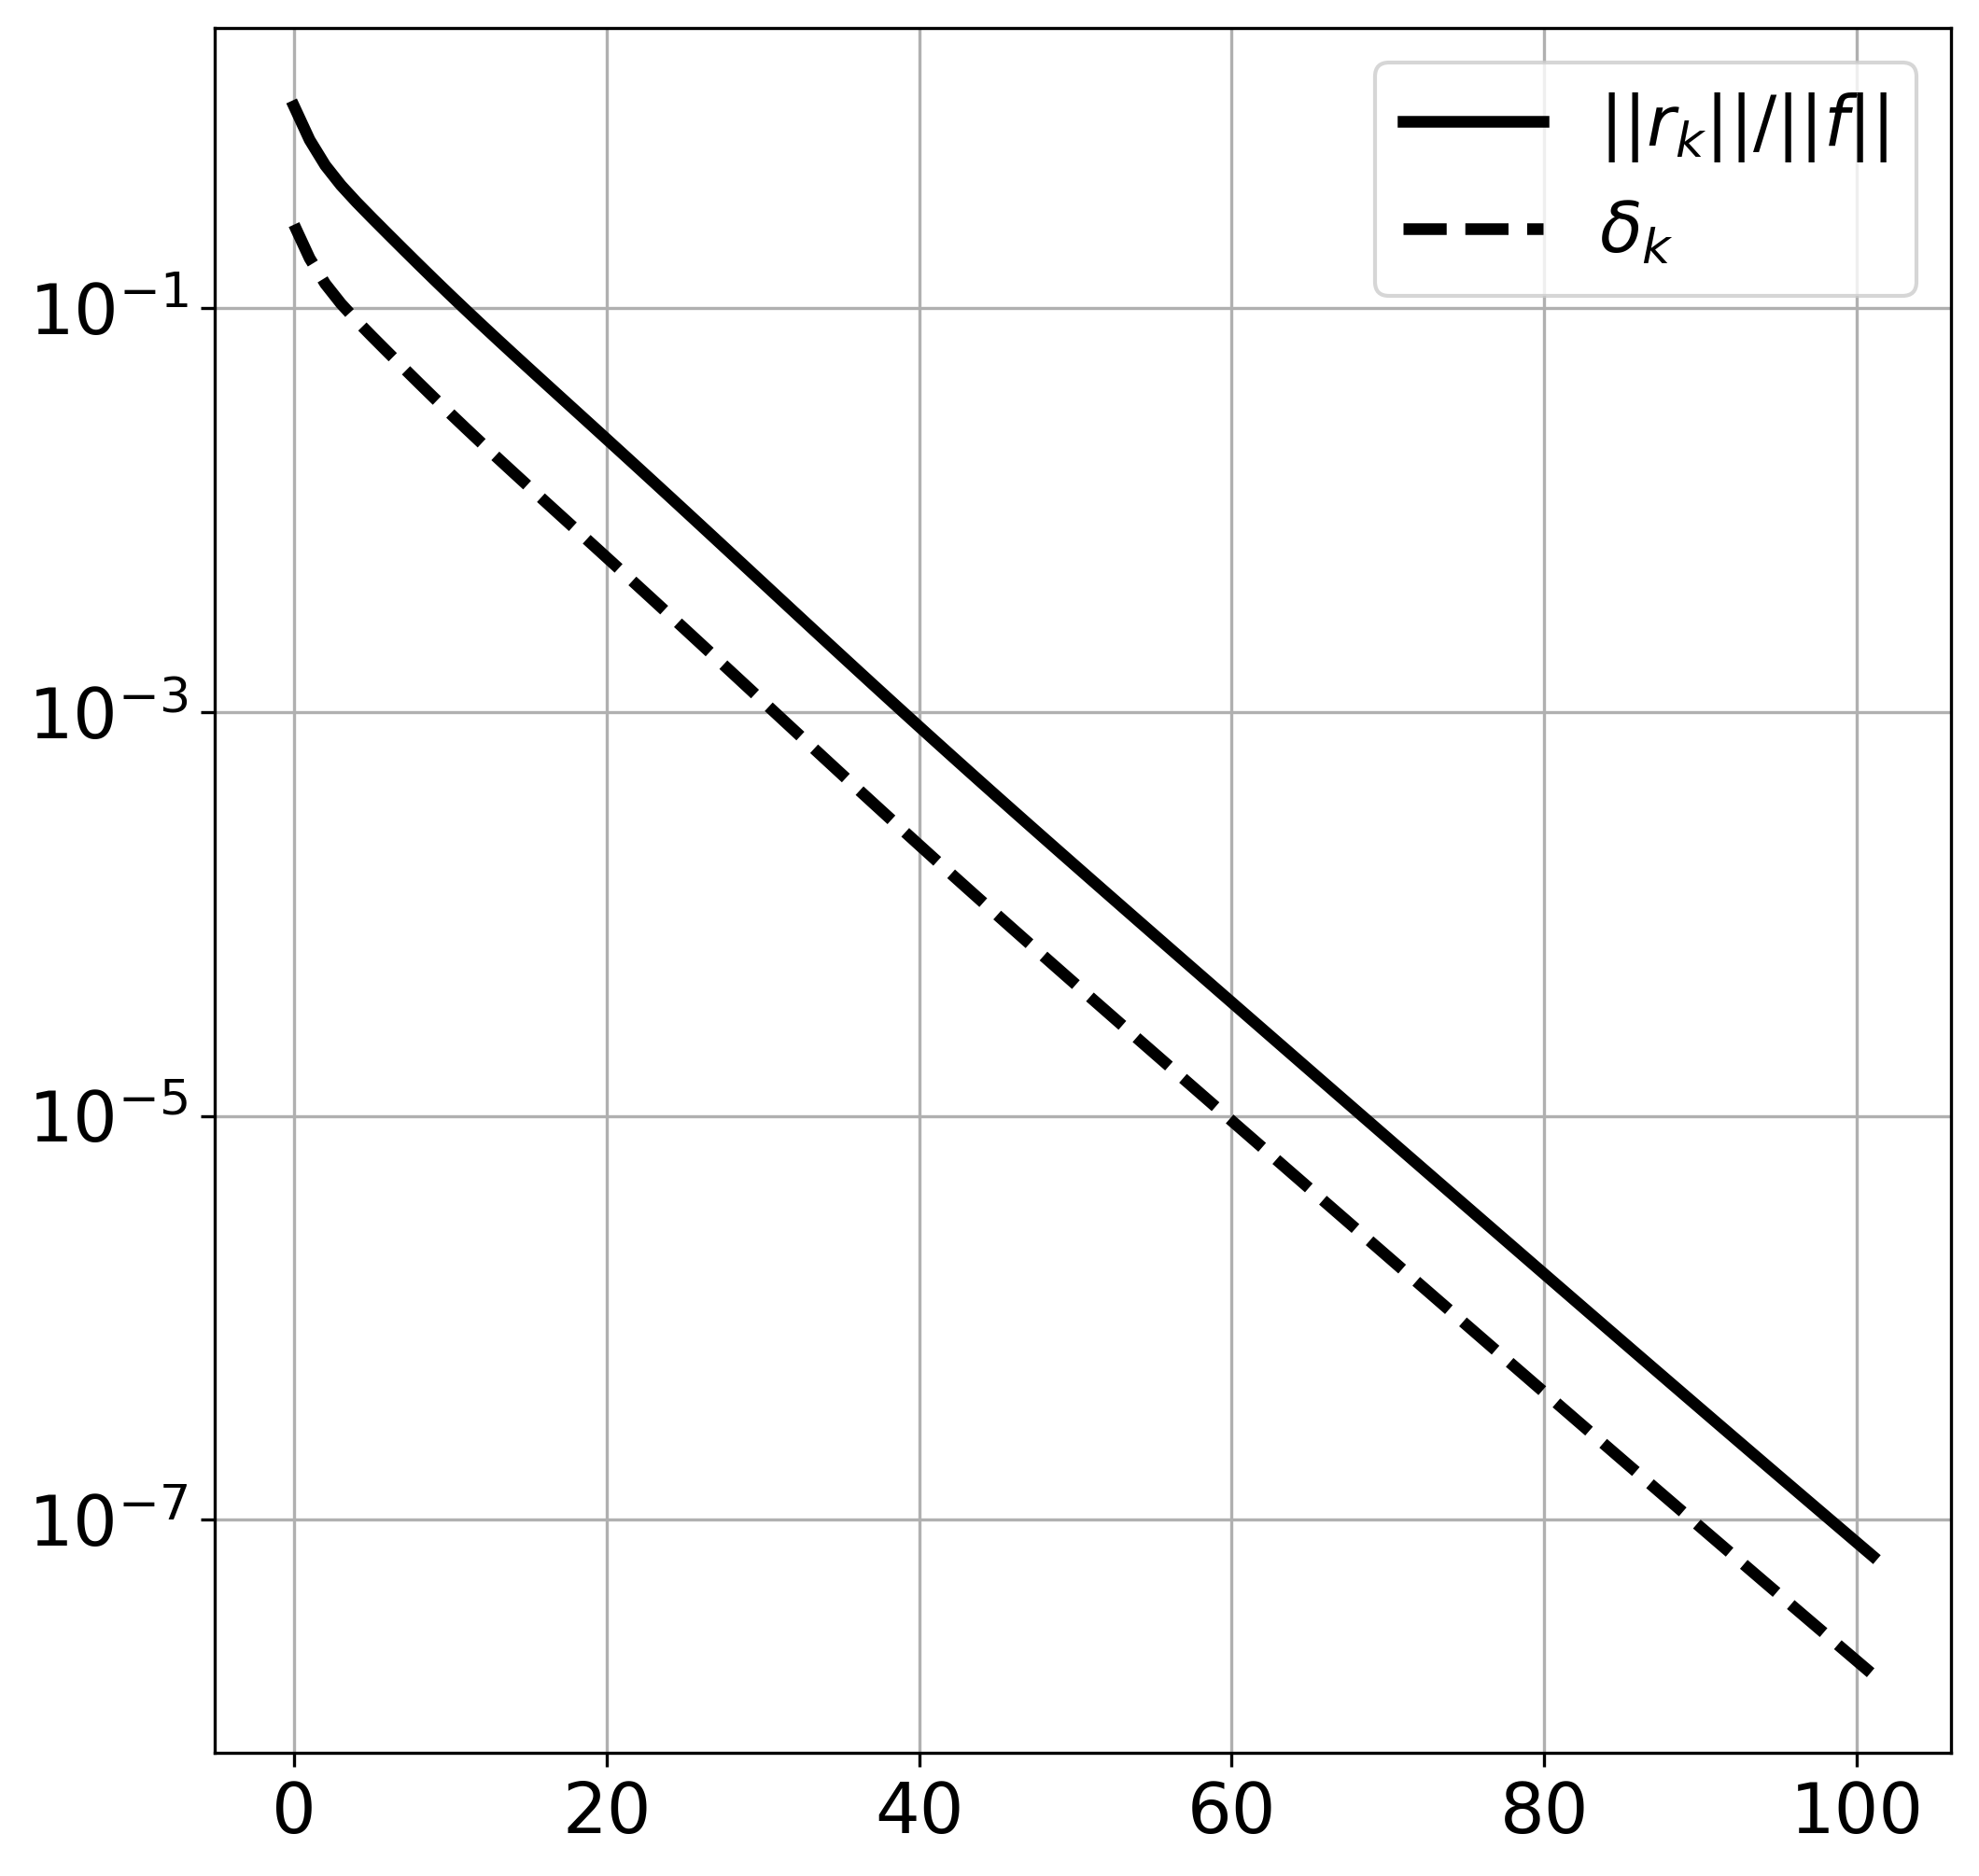

In [516]:
# Отрисовка результатов итераций на малой сетке при найденном параметре
plt.figure(figsize=(8,8), dpi=300)
plt.plot(iters_SIMm, resid_SIMm, label=r"$||r_k|| / ||f||$", linewidth=3, c="black")
plt.plot(iters_SIMm, delta_SIMm, label=r"$\delta_k$", linewidth=3, linestyle="--", c="black")
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

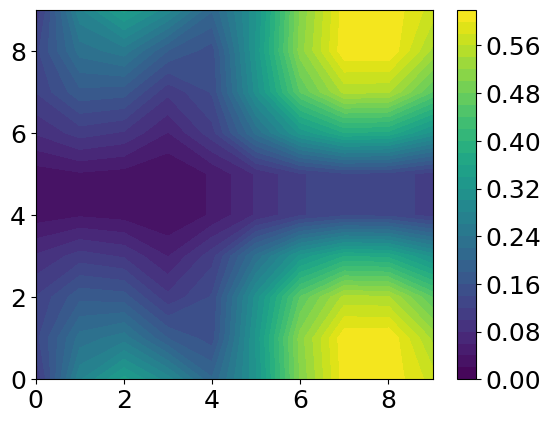

In [519]:
plt.contourf(np.abs(result_SIMm.reshape(N+[3]))[4, :, :, 0].real, 30)
plt.colorbar()

# Быстрые умножения

In [409]:
def make_grid_3d(N, L, center, **kwargs):
    """
    :param N: список из трех элементов [n_3, n_2, n_1] целых чисел, числа ячеек 
    дискретизации объемной области решения системой прямоугольных параллелепипедов
    :param L: список из трех элементов [l_3, l_2, l_1] вещественных чисел, длины
    дисркетизируемой объемной области решения по каждой из направления декартовой сетки координат
    :param center: список трех элементов [с_3, с_2, с_1] вещественных чисел расположения центра
    объемной области решения в трехмерной системы координат для вариации расположения области решения
    
    :return: (grid, volume), где grid - сетка в трехмерной системе координат с узловыми точками
    прямоугольных ячеек, volume - объем разбиения (прямоугольного параллелепипеда)
     """
    
    # Границы сетки
    x = np.linspace(-L[0]/2 - center[0], L[0]/2 - center[0], N[0] + 1)
    y = np.linspace(-L[1]/2 - center[1], L[1]/2 - center[1], N[1] + 1)
    z = np.linspace(-L[2]/2 - center[2], L[2]/2 - center[2], N[2] + 1)
    
    # Объем ячейки
    h_x = x[1] - x[0]
    h_y = y[1] - y[0]
    h_z = z[1] - z[0]
    volume = h_x * h_y * h_z
    
    # Середины - точки коллокации
    x = (x[1:] + x[:-1])/2
    y = (y[1:] + y[:-1])/2
    z = (z[1:] + z[:-1])/2
    
    # Сетка - трехмерный тензор, вытянутый в строку размером n_3*n_2*n_1
    grid = np.array(np.meshgrid(x, y, z, indexing='ij')).T
    
    return grid, volume


def step_dielectric_3d(grid,
                       eps_real,
                       eps_imag,
                       x1_bounds,
                       x2_bounds,
                       x3_bounds):
    """
    grid - Тензор (n_1, n_2, n_3, 3) для каждой точки пространства
    eps_real
    """
    if eps_real is None:
        eps_real = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
    if eps_imag is None:
        eps_imag = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
    if x1_bounds is None:
        x1_bounds = [-1.0, 0.5]
    if x2_bounds is None:
        x2_bounds = [-1.0, 1.0]
    if x3_bounds is None:
        x3_bounds = [-1.0, 1.0]

    eps = np.zeros((*grid.shape, 3)) + 0.0j
    indexes = ((grid[..., 0] >= x1_bounds[0]) * (grid[..., 0] <= x1_bounds[1]) *
               (grid[..., 1] >= x2_bounds[0]) * (grid[..., 1] <= x2_bounds[1]) *
               (grid[..., 2] >= x3_bounds[0]) * (grid[..., 2] <= x3_bounds[1]))
    eps[indexes] = np.array(eps_real) + 1j * np.array(eps_imag)
    return eps, indexes


def ellipsis_dielectric_3d(grid,
                           eps_real,
                           eps_imag,
                           center,
                           radius):
    if eps_real is None:
        eps_real = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
    if eps_imag is None:
        eps_imag = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
    if center is None:
        center = [0.0, 0.0, 0.0]
    if radius is None:
        radius = [1.0, 1.0, 1.0]
    eps = np.zeros((*grid.shape, 3)) + 0j
    indexes = (
        ((grid[..., 0] - center[0]) ** 2) / (radius[0] ** 2) +
        ((grid[..., 1] - center[1]) ** 2) / (radius[1] ** 2) +
        ((grid[..., 2] - center[2]) ** 2) / (radius[2] ** 2)
    ) <= 1
    eps[indexes] = np.array(eps_real) + 1j * np.array(eps_imag)
    return eps, indexes


def apply_dielectric_3d(grid,
                        eps_vec=None, **kwargs):
    if eps_vec is None:
        eps_vec = [
            {
                "type": "step",
                "eps_real": [[1.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0],
                             [0.0, 0.0, 1.0]],
                "eps_imag": [[0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0]],
                "x1_bounds": [-1.0, 0.0],
                "x2_bounds": [-1.0, 1.0],
                "x3_bounds": [-1.0, 1.0]
            },
            {
                "type": "ellipsis",
                "eps_real": [[1.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0],
                             [0.0, 0.0, 1.0]],
                "eps_imag": [[1.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0],
                             [0.0, 0.0, 1.0]],
                "center": [0.0, 0.0, 0.0],
                "radius": [1.0, 1.0, 1.0]
            }
        ]

    eps = np.zeros((*grid.shape, 3)) + 0j
    indexes = np.zeros(grid.shape[:-1], dtype=bool)
    for num, element in enumerate(eps_vec):
        if element.get("type") == "step":
            eps_d, indexes_d = step_dielectric_3d(grid=grid,
                                                  eps_real=element.get('eps_real'),
                                                  eps_imag=element.get('eps_imag'),
                                                  x1_bounds=element.get('x1_bounds'),
                                                  x2_bounds=element.get('x2_bounds'),
                                                  x3_bounds=element.get('x3_bounds'))
        elif element.get("type") == "ellipsis":
            eps_d, indexes_d = ellipsis_dielectric_3d(grid=grid,
                                                      eps_real=element.get('eps_real'),
                                                      eps_imag=element.get('eps_imag'),
                                                      center=element.get('center'),
                                                      radius=element.get('radius'))
        else:
            continue
        indexes += indexes_d
        eps += eps_d
    return eps, indexes

In [410]:
# Быстрое умножение блочно-Тёплицевой матрицы на вектор
def fast_bbtmv_mul(col_arr, row_arr, vec_arr):
    """

    :param col_arr:
    :param row_arr:
    :param vec_arr:

    :return:
    """
    
    n_3, n_2, n_1 = col_arr.shape
    
    circulant_tensor = np.zeros((2*n_3, 2*n_2, 2*n_1)) + 0.0j
    x_arr = np.zeros((2*n_3, 2*n_2, 2*n_1)) + 0.0j

    circulant_tensor[:n_3, :n_2, :n_1] = row_arr[:n_3, :n_2, :n_1]
    circulant_tensor[(n_3 + 1):(2*n_3), :n_2, :n_1] = col_arr[n_3:0:-1, :n_2, :n_1]
    circulant_tensor[:n_3, (n_2 + 1):(2*n_2), :n_1] = col_arr[:n_3, n_2:0:-1, :n_1]
    circulant_tensor[:n_3, :n_2, (n_1 + 1):(2*n_1)] = col_arr[:n_3, :n_2, n_1:0:-1]
    circulant_tensor[(n_3 + 1):(2*n_3), (n_2 + 1):(2*n_2), :n_1] = col_arr[n_3:0:-1, n_2:0:-1, :n_1]
    circulant_tensor[:n_3, (n_2 + 1):(2*n_2), (n_1 + 1):(2*n_1)] = col_arr[:n_3, n_2:0:-1, n_1:0:-1]
    circulant_tensor[(n_3 + 1):(2*n_3), :n_2, (n_1 + 1):(2*n_1)] = col_arr[n_3:0:-1, :n_2, n_1:0:-1]
    circulant_tensor[(n_3 + 1):(2*n_3), (n_2 + 1):(2*n_2), (n_1 + 1):(2*n_1)] = col_arr[n_3:0:-1, n_2:0:-1, n_1:0:-1]

    x_arr[:n_3, :n_2, :n_1] = vec_arr[:n_3, :n_2, :n_1]

    circulant_tensor = np.fft.fftn(circulant_tensor) * np.fft.fftn(x_arr)
    circulant_tensor = np.fft.ifftn(circulant_tensor)

    return circulant_tensor[:n_3, :n_2, :n_1]


# Функция подготовки блочно-Тёплицевой матрицы с (1,1)-элементами в блочно-Циркулянтную матрицу с БПФ
def prep_fftbbmatrix(col_arr, row_arr):
    """
    ПАРАМЕТРЫ
    
    :param col_arr: колонка блочно-Тёлпицевой матрицы размерности (n_3, n_2, n_1)
    :param row_arr: строка блочно-Тёлпицевой матрицы размерности (n_3, n_2, n_1)
    
    ВОЗВРАЩАЕТ
    
    return: циркулянт-тензор блочно-Тёплицевой матрицы размерности (2*n_3, 2*n_2, 2*n_1)
    """
    
    # Размерности тензоров
    n_3, n_2, n_1 = col_arr.shape
    
    # Результирующий циркулянт 
    circulant_tensor = np.zeros((2 * n_3, 2 * n_2, 2 * n_1)) + 0.0j
    
    # Отражения для разширенной дискретизации
    circulant_tensor[:n_3, :n_2, :n_1] = row_arr[:n_3, :n_2, :n_1]
    circulant_tensor[(n_3 + 1):(2*n_3), :n_2, :n_1] = col_arr[n_3:0:-1, :n_2, :n_1]
    circulant_tensor[:n_3, (n_2 + 1):(2*n_2), :n_1] = col_arr[:n_3, n_2:0:-1, :n_1]
    circulant_tensor[:n_3, :n_2, (n_1 + 1):(2*n_1)] = col_arr[:n_3, :n_2, n_1:0:-1]
    circulant_tensor[(n_3 + 1):(2*n_3), (n_2 + 1):(2*n_2), :n_1] = col_arr[n_3:0:-1, n_2:0:-1, :n_1]
    circulant_tensor[:n_3, (n_2 + 1):(2*n_2), (n_1 + 1):(2*n_1)] = col_arr[:n_3, n_2:0:-1, n_1:0:-1]
    circulant_tensor[(n_3 + 1):(2*n_3), :n_2, (n_1 + 1):(2*n_1)] = col_arr[n_3:0:-1, :n_2, n_1:0:-1]
    circulant_tensor[(n_3 + 1):(2*n_3), (n_2 + 1):(2*n_2), (n_1 + 1):(2*n_1)] = col_arr[n_3:0:-1, n_2:0:-1, n_1:0:-1]
    circulant_tensor = np.fft.fftn(circulant_tensor)
    
    return circulant_tensor


# Функция подготовки блочно-Тёплицевого тензора с (3,3)-элементами в блочно-Циркулянтный тензор с БПФ
def prep_fftbbtensor(col_arr, row_arr):
    """
    ПАРАМЕТРЫ
    
    :param col_arr: колонка блочно-Тёлпицевого тензора размерности (n_3, n_2, n_1, 3, 3)
    :param row_arr: строка блочно-Тёлпицевого тензора размерности (n_3, n_2, n_1, 3, 3)
    
    ВОЗВРАЩАЕТ
    
    return: циркулянт-тензор блочно-Тёплицевой матрицы размерности (2*n_3, 2*n_2, 2*n_1, 3, 3)
    """
    
    # Размерности задачи
    n_3, n_2, n_1, _, _ = col_arr.shape
    
    # Результирующий циркулянт-тензор
    result = np.zeros((2*n_3, 2*n_2, 2*n_1, 3, 3)) + 0.0j
    
    # Процесс подготовки тензора
    for row in range(3):
        for col in range(3):
            result[..., row, col] = prep_fftbbmatrix(col_arr[..., row, col], row_arr[..., row, col])
    
    return result


# Фнукция быстрого умножения подготовленного блочно-Циркулянтного БПФ тензора на вектор с ОБПФ
def prep_fbbtmv_ifft(prep_fft_arr, vec_arr):
    """
    ПАРАМЕТРЫ
    
    :param prep_fft_arr: подготовленный БПФ-циркулянт размерности (2*n_3, 2*n_2, 2*n_1)
    :param vec_arr: вектор размерности (n_3, n_2, n_1)
    
    ВОЗВРАЩАЕТ
    return: результат быстрого умножения блочно-Тёплицевой матрицы на вектор размерности (n_3, n_2, n_1)
    """
    # Собираю размерности для результата умножений
    n_3, n_2, n_1 = vec_arr.shape
    
    # Вектор, на который умножаем дополняется нулями в расширенной дискретизации
    x_arr = np.zeros((2*n_3, 2*n_2, 2*n_1)) + 0.0j
    
    # Заполнение вектора-операнда в исходной дискретизации
    x_arr[:n_3, :n_2, :n_1] = vec_arr[:n_3, :n_2, :n_1]
    
    # Осуществление умножения и срез необходимого результата
    result = np.fft.ifftn(prep_fft_arr * np.fft.fftn(x_arr))[:n_3, :n_2, :n_1]

    return result


# Фнукция быстрого умножения подготовленного блочно-Циркулянтного БПФ тензора на вектор без ОБПФ
def prep_fbbtmv(prep_fft_arr, vec_arr):
    """
    ПАРАМЕТРЫ
    
    :param prep_fft_arr: подготовленный БПФ-циркулянт размерности (2*n_3, 2*n_2, 2*n_1)
    :param vec_arr: вектор размерности (n_3, n_2, n_1)
    
    ВОЗВРАЩАЕТ
    :return: результат быстрого умножения блочно-Тёплицевой матрицы на вектор размерности (2*n_3, 2*n_2, 2*n_1)
    """
    # Собираю размерности для результата умножений
    n_3, n_2, n_1 = vec_arr.shape
    
    # Вектор, на который умножаем дополняется нулями в расширенной дискретизации
    x_arr = np.zeros((2*n_3, 2*n_2, 2*n_1)) + 0.0j
    
    # Заполнение вектора-операнда в исходной дискретизации
    x_arr[:n_3, :n_2, :n_1] = vec_arr[:n_3, :n_2, :n_1]
    
    # Осуществление умножения и срез необходимого результата
    result = prep_fft_arr * np.fft.fftn(x_arr)

    return result

# Определение ядра интегрального оператора

$$
    B_{nm}(p-q) = \int_{\Pi_q} G(R) \left[(\frac{3}{R^2} - \frac{3ik_0}{R} - k_0^2)\alpha_n \alpha_m + (k_0^2 + \frac{ik_0}{R}-\frac{1}{R^2})\delta_{nm} \right] dy, p\ne q
$$

$$
\alpha_n = \frac{x_n(p)-y_n}{|x(p)-y|}, n=1,2,3, \quad \eta_{mk} = \varepsilon(y(q)) - \delta_{mk}, \quad R = \sqrt{\sum_{i=1}^{3} {(y_i - x_i(p))^2}}, \quad B_{nm}(0,0,0) = (-1/3)I
$$


In [411]:
def init_operator(grid, volume, discret, distance, k, eps, kernel):
    dist_coef_1 = np.zeros(np.prod(discret)) + 0.0j
    dist_coef_1[1:] = (3 / (distance[1:] ** 2)) - ((3j * k) / distance[1:]) - (k ** 2)
    alpha = np.zeros((np.prod(discret), 3))
    alpha[1:, :] = (grid[0, :] - grid[1:, :]) / distance[1:].reshape(-1, 1)
    indexing_matrix = np.einsum('...j,...i->...ji', alpha, alpha)
    part_1 = indexing_matrix * dist_coef_1.reshape(-1, 1, 1)

    dist_coef_2 = np.zeros(np.prod(discret)) + 0.0j
    dist_coef_2[1:] = (k ** 2) + ((1j * k) / distance[1:]) - (1 / (distance[1:] ** 2))
    part_2 = np.eye(3).reshape(-1, 3, 3) * dist_coef_2.reshape(-1, 1, 1)

    gr = np.zeros(np.prod(discret)) + 0.0j
    gr[1:] = kernel(distance[1:], k)
    result = gr.reshape(-1, 1, 1) * (part_1 + part_2) * volume.reshape(-1, 1)
    eps = eps.reshape(-1, 3, 3) - (np.eye(3).reshape(-1, 3, 3))
    result[0, :, :] = -(1 / 3) * np.eye(3)
    return result, gr, eps


# Расчет вектора расптространения волны
def wave_3d(x, k=1, orient=[0.0, 0.0, 1.0], sign=1, amplitude=[1.0, 0.0, 0.0], phi0=0.0, **kwargs):
    # Нормировка направления распространения
    orient = np.array(orient) / np.linalg.norm(np.array(orient), 2)
    
    # Превращение амплитуды в тензор
    amplitude = np.array(amplitude)[np.newaxis, np.newaxis, np.newaxis]
    
    # Расчет волны вдоль направления
    wave = np.exp(sign * 1j * k * (x.dot(orient)) - phi0)
    
    return amplitude * wave[..., np.newaxis]


# Создание Тёплицевого оператора
def init_operator_3d(grid, volume, discret, distance, k, eps, kernel):
    # Размерность результата
    n_3, n_2, n_1, _ = grid.shape
    
    # Результат
    result_row = np.zeros((n_3, n_2, n_1, 3, 3)) + 0.0j
    
    # Результат
    result_col = np.zeros((n_3, n_2, n_1, 3, 3)) + 0.0j
    
    # Коэффициенты расстояния
    dist_coef_1 = np.zeros((n_3, n_2, n_1)) + 0.0j
    dist_coef_1 = (3 / (distance ** 2)) - ((3j * k) / distance) - (k ** 2)
    dist_coef_1[0, 0, 0] = 0.0 + 0.0j
    
    dist_coef_2 = np.zeros((n_3, n_2, n_1)) + 0.0j
    dist_coef_2 = (k ** 2) + ((1j * k) / distance) - (1 / (distance ** 2))
    dist_coef_2[0, 0, 0] = 0.0 + 0.0j
    
    # Расчет альфа nm
    alpha_row = np.zeros((n_3, n_2, n_1, 3)) + 0.0j    
    alpha_row = (grid[0, 0, 0, :] - grid) / distance[..., np.newaxis]
    alpha_row[0, 0, 0] = np.array([0.0, 0.0, 0.0])
    indexing_matrix_row = alpha_row[:, :, :, np.newaxis, :] * alpha_row[:, :, :, :, np.newaxis]
    
    part_1 = indexing_matrix_row * dist_coef_1[..., np.newaxis, np.newaxis]
    part_2 = np.eye(3)[np.newaxis, np.newaxis, np.newaxis, :, :] * dist_coef_2[..., np.newaxis, np.newaxis]
    
    # Функция Грина
    gr = np.zeros((n_3, n_2, n_1)) + 0.0j
    gr = kernel(distance, k)
    gr[0, 0, 0] = 0.0 + 0.0j
    
    result_row = gr[..., np.newaxis, np.newaxis] * (part_1 + part_2) * volume
    result_row[0, 0, 0, :, :] = -(1 / 3) * np.eye(3) + 0.0j
    
    # Расчет альфа nm
    alpha_col = np.zeros((n_3, n_2, n_1, 3)) + 0.0j    
    alpha_col = (grid - grid[0, 0, 0, :]) / distance[..., np.newaxis]
    alpha_col[0, 0, 0] = np.array([0.0, 0.0, 0.0])
    indexing_matrix_col = alpha_col[:, :, :, np.newaxis, :] * alpha_col[:, :, :, :, np.newaxis]
    
    part_1 = indexing_matrix_col * dist_coef_1[..., np.newaxis, np.newaxis]
    part_2 = np.eye(3)[np.newaxis, np.newaxis, np.newaxis, :, :] * dist_coef_2[..., np.newaxis, np.newaxis]
    
    # Функция Грина
    gr = np.zeros((n_3, n_2, n_1)) + 0.0j
    gr = kernel(distance, k)
    gr[0, 0, 0] = 0.0 + 0.0j
    
    result_col = gr[..., np.newaxis, np.newaxis] * (part_1 + part_2) * volume
    result_col[0, 0, 0, :, :] = -(1 / 3) * np.eye(3) + 0.0j

    eps = eps - np.eye(3)[np.newaxis, np.newaxis, np.newaxis, :, :]

    return result_row, result_col, eps

# Скрипт решения задачи

In [412]:
n_1 = problem_config.get('N')[0]
n_2 = problem_config.get('N')[1]
n_3 = problem_config.get('N')[2]
k_wave = problem_config.get('k')
amplitude = problem_config.get('amplitude')
orient = problem_config.get('orient')

grid, volume = make_grid(**problem_config)
eta, ind = apply_dielectric(grid, **problem_config)
dists = np.linalg.norm(grid[0, :] - grid[:,:], 2, axis=1)
G, gr, eps = init_operator(grid, volume, problem_config.get('N'), dists, problem_config.get('k'), eta, kernel)
f_wave = wave(grid, k, orient, 1, amplitude)

random_vec = np.ones_like(f_wave)  + 1.0j

In [413]:
grid_3d, volume = make_grid_3d(**problem_config)
grid_3d
print(grid_3d.shape)

dists_3d = np.linalg.norm(grid_3d[0,0,0] - grid_3d, 2, axis=-1)
print(dists_3d.shape)


eta_3d, ind_3d = apply_dielectric_3d(grid_3d, **problem_config)
print(eta_3d.shape)

f_wave_3d = wave_3d(grid_3d, k, orient, 1, amplitude)
print(f_wave_3d.shape)

G_3d_row, G_3d_col, eps_3d = init_operator_3d(grid_3d, volume, problem_config.get('N'), dists_3d, problem_config.get('k'), eta, kernel)
print(G_3d_row.shape)

random_vec_3d = np.ones_like(f_wave_3d)  + 1.0j

(10, 10, 10, 3)
(10, 10, 10)
(10, 10, 10, 3, 3)
(10, 10, 10, 3)
(10, 10, 10, 3, 3)


C:\Users\user\AppData\Local\Temp\ipykernel_26612\2032351259.py:48: RuntimeWarning: divide by zero encountered in divide
  dist_coef_1 = (3 / (distance ** 2)) - ((3j * k) / distance) - (k ** 2)
C:\Users\user\AppData\Local\Temp\ipykernel_26612\2032351259.py:48: RuntimeWarning: invalid value encountered in divide
  dist_coef_1 = (3 / (distance ** 2)) - ((3j * k) / distance) - (k ** 2)
C:\Users\user\AppData\Local\Temp\ipykernel_26612\2032351259.py:52: RuntimeWarning: divide by zero encountered in divide
  dist_coef_2 = (k ** 2) + ((1j * k) / distance) - (1 / (distance ** 2))
C:\Users\user\AppData\Local\Temp\ipykernel_26612\2032351259.py:52: RuntimeWarning: invalid value encountered in divide
  dist_coef_2 = (k ** 2) + ((1j * k) / distance) - (1 / (distance ** 2))
C:\Users\user\AppData\Local\Temp\ipykernel_26612\2032351259.py:57: RuntimeWarning: invalid value encountered in divide
  alpha_row = (grid[0, 0, 0, :] - grid) / distance[..., np.newaxis]
C:\Users\user\AppData\Local\Temp\ipykernel_

In [414]:
i = 0
j = 2

prep_Gij = prep_fftbbmatrix(G_3d_col[..., i, j], G_3d_row[..., i, j])
#prep_Gij = prep_fftbbmatrix(G_3d[..., i, j], G_3d[..., j, i])
result_Gij_fast = prep_fbbtmv_ifft(prep_Gij, random_vec_3d[..., j])

result_Gij_classic = B_matrix[..., i, j] @ random_vec[..., j]

diffr = (result_Gij_fast.reshape(-1) - result_Gij_classic)
np.sum(np.abs(diffr)).round(2)

1005.82

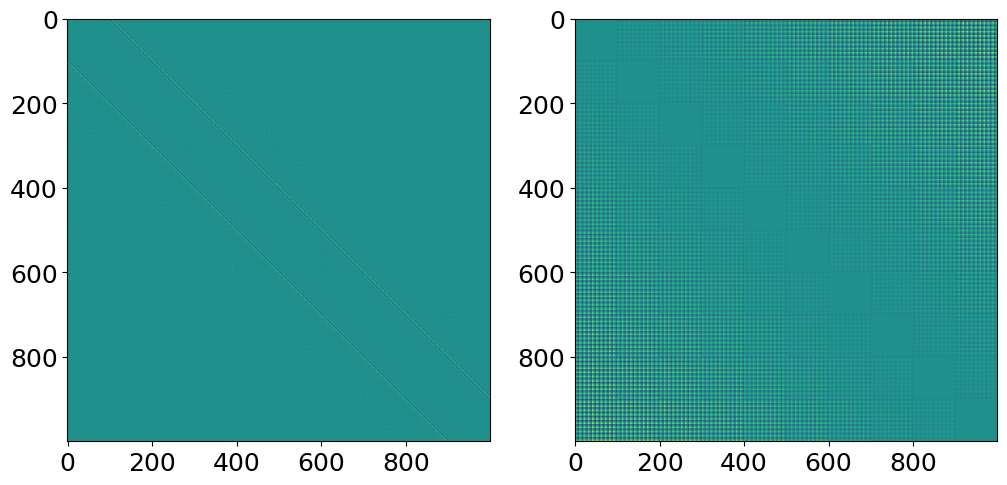

In [415]:
fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].imshow(B_matrix[:, :, i, j].real)
ax[1].imshow(B_matrix[:, :, i, j].imag)

In [416]:
B_matrix[:, 0, i, j].round(3) - G_3d_col[..., j, i].reshape(-1, ).round(3)

array([-0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+

In [417]:
np.sum(np.abs(G_3d_row.reshape(-1, 3, 3) - B_matrix[0, ...]))

5.00539163694562e-16

In [418]:
result_mult_classic = np.einsum("ijkl,jl->ik", B_matrix, f_wave)

In [419]:
prep_G = prep_fftbbtensor(G_3d_row, G_3d_col)
result_mult_fast = toeplitz_3d_matvec(prep_G, f_wave_3d)

In [420]:
result_mult_fast.reshape(-1, 3)

array([[ 0.2297464 -0.04931719j,  0.21334144-0.11486242j,
        -0.19387003+0.33910109j],
       [ 0.29356295-0.08621265j,  0.27446647-0.12345556j,
        -0.24894715+0.3647136j ],
       [ 0.33625459-0.07744243j,  0.31742381-0.09784435j,
        -0.27693065+0.33864436j],
       ...,
       [ 0.34757623+0.1063928j ,  0.31627894+0.14076784j,
        -0.31427548+0.10820677j],
       [ 0.30746233+0.12078429j,  0.27288552+0.16562149j,
        -0.29982769+0.05781353j],
       [ 0.24439644+0.0907943j ,  0.21134578+0.15603426j,
        -0.2569349 +0.05201033j]])

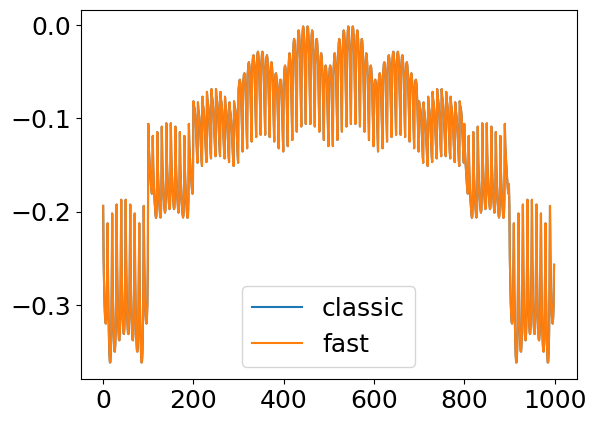

In [421]:
dim = 2

plt.plot(result_mult_classic[..., dim].real, label = "classic")
plt.plot(result_mult_fast.reshape(-1, 3)[..., dim].real, label = "fast")
plt.legend()

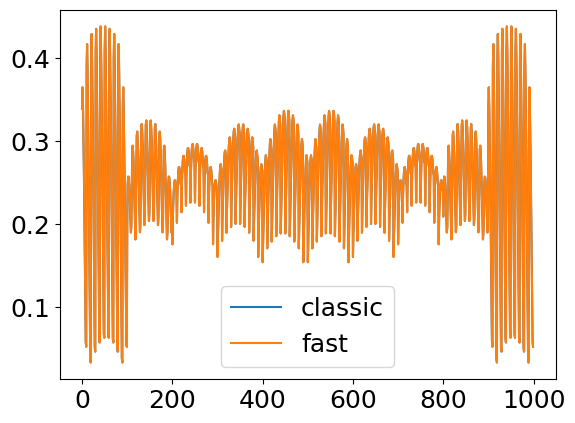

In [422]:
plt.plot(result_mult_classic[..., dim].imag, label = "classic")
plt.plot(result_mult_fast.reshape(-1, 3)[..., dim].imag, label = "fast")
plt.legend()

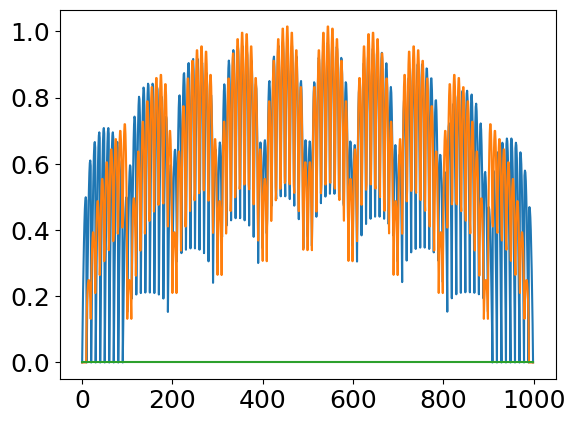

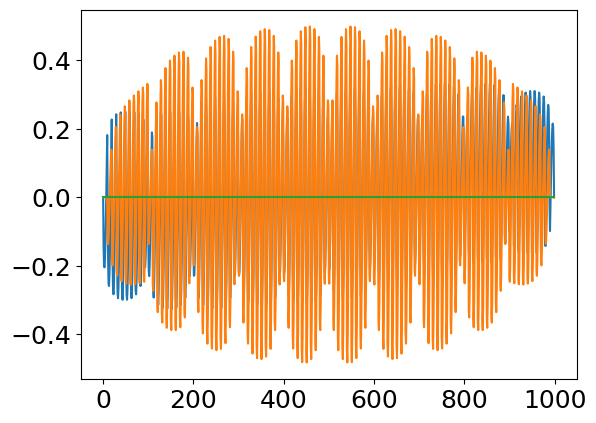

In [423]:
plt.plot(result_mult_fast.reshape(-1, 3).real - result_mult_classic.real)
plt.show()

plt.plot(result_mult_fast.reshape(-1, 3).imag - result_mult_classic.imag)
plt.show()

In [424]:
def is_toeplitz_2d(A: np.ndarray) -> bool:
    """
    Проверяет, что квадратная матрица A является Тёплицевой.
    Условие Тёплица: A[i, j] == A[i-1, j-1] для всех i, j, где это применимо.
    """
    n = A.shape[0]
    # Предполагаем, что A квадратная
    for i in range(1, n):
        for j in range(1, n):
            if A[i, j] != A[i-1, j-1]:
                return False
    return True


def is_block_toeplitz_2nd_level(block_2d: np.ndarray, n1: int, n2: int) -> bool:
    """
    Проверяет, является ли заданная подматрица block_2d (размером n2*n1 x n2*n1)
    блочно-Тёплицевой второго уровня, где:
      - Всю матрицу можно рассматривать как (n2 x n2) блоков.
      - Каждый блок имеет размер (n1 x n1).
      - В блоковых индексах (p, q) должно выполняться свойство Тёплица (зависимость только от p-q).
      - Каждый блок (размером n1 x n1) также должен быть Тёплицевой матрицей в обычном (2D) смысле.
    """

    # Сначала убедимся, что размеры совпадают
    if block_2d.shape != (n2 * n1, n2 * n1):
        return False

    # Переформируем в 4D для удобства:
    # block_reshaped[p, i, q, j] соответствует элементу
    # block_2d[p*n1 + i, q*n1 + j]
    block_reshaped = block_2d.reshape(n2, n1, n2, n1)

    # 1) Проверяем блочное Тёплицево свойство по (p, q):
    #    для p=1..n2-1, q=1..n2-1 блок (p,q) == блок (p-1,q-1).
    for p in range(1, n2):
        for q in range(1, n2):
            # Сравниваем блок (p,q) и (p-1,q-1)
            if not np.array_equal(block_reshaped[p, :, q, :],
                                  block_reshaped[p-1, :, q-1, :]):
                return False

    # 2) Проверяем, что каждый блок (n1 x n1) является 2D-Тёплицевой матрицей
    for p in range(n2):
        for q in range(n2):
            subblock = block_reshaped[p, :, q, :]
            if not is_toeplitz_2d(subblock):
                return False

    return True


def is_block_toeplitz_3rd_level(M: np.ndarray, n1: int, n2: int, n3: int) -> bool:
    """
    Проверяет, является ли матрица M (размером (n3*n2*n1) x (n3*n2*n1))
    блочно-Тёплицевой 3-го уровня, где:
      - На верхнем уровне это (n3 x n3) блоков.
      - Каждый такой блок имеет размер (n2*n1 x n2*n1), и сам должен быть
        блочно-Тёплицевым 2-го уровня (см. is_block_toeplitz_2nd_level).
    """

    # Проверим габариты
    N = n3 * n2 * n1
    if M.shape != (N, N):
        return False

    # Переформируем в 4D: top_blocks[i3, :, j3, :]
    # будет блоком размером (n2*n1 x n2*n1) для пары (i3, j3).
    top_blocks = M.reshape(n3, n2*n1, n3, n2*n1)

    # 1) Проверяем Тёплицево свойство по верхнему уровню (i3, j3):
    #    для i3=1..n3-1, j3=1..n3-1 блок (i3, j3) == блок (i3-1, j3-1).
    for i3 in range(1, n3):
        for j3 in range(1, n3):
            block_current = top_blocks[i3, :, j3, :]
            block_prev    = top_blocks[i3-1, :, j3-1, :]
            if not np.array_equal(block_current, block_prev):
                return False

    # 2) Проверяем, что каждый блок (n2*n1 x n2*n1) является
    #    блочно-Тёплицевым 2-го уровня.
    for i3 in range(n3):
        for j3 in range(n3):
            submatrix_2d = top_blocks[i3, :, j3, :]
            if not is_block_toeplitz_2nd_level(submatrix_2d, n1, n2):
                return False

    return True

In [425]:
def block_toeplitz_multiply(A_blocks, x, n1, n2, n3):
    """
    Умножение несимметричной блочно-Тёплицевой матрицы третьего уровня на вектор с использованием 3D FFT.

    Параметры:
    - A_blocks: numpy.ndarray
        Трехмерный массив размера (n3, n2, n1), представляющий первый столбец блочно-Тёплицевой матрицы A.
    - x: numpy.ndarray
        Вектор размера (n3 * n2 * n1), на который нужно умножить матрицу A.
    - n1, n2, n3: int
        Размеры уровней блочно-Тёплицевой структуры.

    Возвращает:
    - y: numpy.ndarray
        Результат умножения блочно-Тёплицевой матрицы A на вектор x.
    """
    # Преобразуем вектор x в трехмерный массив для удобства работы
    x_reshaped = x.reshape((n3, n2, n1))

    # Расширяем блочно-Тёплицевую структуру до циркулянтной
    A_circulant = np.zeros((2 * n3, 2 * n2, 2 * n1), dtype=np.complex128)
    A_circulant[:n3, :n2, :n1] = A_blocks
    A_circulant[n3+1:, :n2, :n1] = np.flip(A_blocks[1:, :, :], axis=0)
    A_circulant[:n3, n2+1:, :n1] = np.flip(A_blocks[:, 1:, :], axis=1)
    A_circulant[:n3, :n2, n1+1:] = np.flip(A_blocks[:, :, 1:], axis=2)
    A_circulant[n3+1:, n2+1:, :n1] = np.flip(A_blocks[1:, 1:, :], axis=(0, 1))
    A_circulant[:n3, n2+1:, n1+1:] = np.flip(A_blocks[:, 1:, 1:], axis=(1, 2))
    A_circulant[n3+1:, :n2, n1+1:] = np.flip(A_blocks[1:, :, 1:], axis=(0, 2))
    A_circulant[n3+1:, n2+1:, n1+1:] = np.flip(A_blocks[1:, 1:, 1:], axis=(0, 1, 2))

    # Преобразуем x_reshaped до того же размера за счет дополнения нулями
    x_padded = np.zeros((2 * n3, 2 * n2, 2 * n1), dtype=np.complex128)
    x_padded[:n3, :n2, :n1] = x_reshaped

    # Выполняем трехмерное быстрое преобразование Фурье (FFT) для циркулянтной матрицы и вектора
    A_fft = np.fft.fftn(A_circulant)
    x_fft = np.fft.fftn(x_padded)

    # Умножаем в частотной области
    y_fft = A_fft * x_fft

    # Выполняем обратное преобразование Фурье
    y_padded = np.fft.ifftn(y_fft)

    # Извлекаем результат размерности (n3, n2, n1)
    y = y_padded[:n3, :n2, :n1]

    # Преобразуем результат обратно в одномерный вектор
    return y.ravel()

In [426]:
block_toeplitz_multiply(B_matrix[0, :, 0, 2].reshape((n_1, n_2, n_3)), f_wave[..., 2], n_1, n_2, n_3)

array([0.2297464 -0.04931719j, 0.29356295-0.08621265j,
       0.33625459-0.07744243j, 0.36484061-0.04852159j,
       0.38049197-0.00976217j, 0.38304404+0.0326996j ,
       0.37220603+0.07350756j, 0.34757623+0.1063928j ,
       0.30746233+0.12078429j, 0.24439644+0.0907943j ,
       0.28188394-0.07116259j, 0.36405913-0.11749202j,
       0.4199973 -0.10638951j, 0.45700167-0.06798586j,
       0.4768267 -0.0164061j , 0.47943977+0.03988198j,
       0.46454353+0.09356015j, 0.43159145+0.13602501j,
       0.37829591+0.15288679j, 0.29689479+0.11363376j,
       0.30893021-0.07806748j, 0.39607615-0.12512296j,
       0.45700913-0.11405853j, 0.4975763 -0.07350322j,
       0.51923518-0.01827835j, 0.52189472+0.04216445j,
       0.50525258+0.09952574j, 0.46881094+0.14421602j,
       0.41057006+0.16114491j, 0.32421608+0.12129611j,
       0.32345957-0.0802671j , 0.41211509-0.12683093j,
       0.47487694-0.11578858j, 0.51692386-0.0748331j ,
       0.53939379-0.01869906j, 0.54208467+0.04286171j,
       0.5

In [427]:
B_matrix[:, :, 0, 2] @ f_wave[:, 2]

array([ 0.2297464 -4.93171860e-02j,  0.17567899+6.03542771e-02j,
        0.12586939+1.21681162e-01j,  0.07368474+1.56237716e-01j,
        0.01895804+1.70219507e-01j, -0.03663493+1.65329511e-01j,
       -0.09104843+1.41653892e-01j, -0.14261376+9.76600582e-02j,
       -0.19151196+2.73170377e-02j, -0.24439644-9.07942988e-02j,
        0.28188394-7.11625941e-02j,  0.21541508+6.77912180e-02j,
        0.15397365+1.46906204e-01j,  0.09055591+1.91275122e-01j,
        0.0244721 +2.09672030e-01j, -0.04256492+2.04666448e-01j,
       -0.10832986+1.76346106e-01j, -0.17111707+1.22314973e-01j,
       -0.2316305 +3.39666062e-02j, -0.29689479-1.13633758e-01j,
        0.30893021-7.80674828e-02j,  0.23862278+7.12261787e-02j,
        0.17115583+1.59600607e-01j,  0.10100785+2.10042795e-01j,
        0.02788311+2.31340536e-01j, -0.04629282+2.26246889e-01j,
       -0.11909439+1.94850775e-01j, -0.18860329+1.34574981e-01j,
       -0.25512965+3.68016215e-02j, -0.32421608-1.21296114e-01j,
        0.32345957-8.0267

# Быстрое блочное умножение Теплицевого тензора на вектор

In [536]:
import numba as nb
from rocket_fft import numpy_like, scipy_like
numpy_like()

# Слабая реализация алгоритма, для которой нужно иметь при себе 2 * (n*n, n*n*n) данных

@nb.njit()
def jit_fft(x):
    return np.fft.fft(x)


@nb.njit()
def jit_ifft(x):
    return np.fft.ifft(x)


# Подготовка коэффициентов в блоках блочно-Тёплицевой матрицы
@nb.njit()
def prep_coeffs_1d(block, n):
    result_array = np.zeros((2*n,)) + 0.0j
    result_array[:n] = block[0, :n]
    result_array[n+1:] = block[n:0:-1, 0]
    result_array = jit_fft(result_array)
    return result_array


# Подготовка коэффициентов в блоках блочно-Тёплицевой матрицы
@nb.njit()
def prep_coeffs_2d(block_2d, n):
    coeffs = np.zeros((2*n-1, 2*n)) + 0.0j
#     row_b = []
#     col_b = []
    row_blocks = block_2d[:n, :]
    col_blocks = block_2d[:, :n]
    for i in nb.prange(n):
        row_b = prep_coeffs_1d(row_blocks[:, i*n:(i+1)*n], n)
        col_b = prep_coeffs_1d(col_blocks[i*n:(i+1)*n, :], n)
        coeffs[(n-1) - i] = row_b
        coeffs[(n-1) + i] = col_b
    return coeffs


# Подготовка коэффициентов в блоках блочно-Тёплицевой матрицы
@nb.njit()
def prep_coeffs_3d(row_blocks, col_blocks, n):
    coeffs = np.zeros((2*n-1, 2*n-1, 2*n)) + 0.0j
#     row_b = []
#     col_b = []
    for i in nb.prange(n):
        row_b = prep_coeffs_2d(row_blocks[:, i*n*n:(i+1)*n*n], n)
        col_b = prep_coeffs_2d(col_blocks[i*n*n:(i+1)*n*n, :], n)
        coeffs[(n-1) + i] = col_b
        coeffs[(n-1) - i] = row_b
    return coeffs


# Одномерное умножение по Фурье
@nb.njit()
def t_mult_1d(prep_coeffs_1d, vec, n):
    vec_pad = np.zeros((2*n,)) + 0.0j
    vec_pad[:n] = vec
    vec_pad = jit_fft(vec_pad)
    result = jit_ifft(prep_coeffs_1d * vec_pad)[:n]
    return result
    

@nb.njit()
def t_mult_2d(list_prep_2d, vec_block, n):
    result = np.zeros(vec_block.shape) + 0.0j
    for i in nb.prange(n):
        for j in nb.prange(n):
            block_mult = list_prep_2d[(n-1)+i-j]
            vec_mult = vec_block[j*n:(j+1)*n]
            result[i*n:(i+1)*n] += t_mult_1d(block_mult, vec_mult, n)
    return result


@nb.njit()
def t_mult_3d(list_prep_3d, vec, n):
    result = np.zeros(vec.shape) + 0.0j
    for i in nb.prange(n):
        for j in nb.prange(n):
            block_2d = list_prep_3d[(n-1)+i-j]
            vec_block = vec[j*n*n:(j+1)*n*n]
            result[i*n*n:(i+1)*n*n] += t_mult_2d(block_2d, vec_block, n)
    
    return result


# Функция заполнения элементов тензора коэффициентами задачи
def init_operator_3dEM(grid, volume, n, k, kernel):
    """
    ПАРАМЕТРЫ
    
    :param grid: массив np.ndarray (n*n*n, 3) - трехмерная сетка задачи
    :param volume: вещественное число - объем куба области дискретизации
    :param n: целое число - дискретизации вдоль одной оси
    :param k: вещественное число - волновое число задачи
    :param kernel: функция, рассчитывающая функцию Грина системы
    
    
    ВОЗВРАЩАЕТ 
    :return: 
        B_row(n*n*n, 3,3) - тензор первой строки оператора, 
        B_row_cols(n*n*n, 3,3) - тензор блоков-столбцов при строках оператора,  
        B_col(n*n*n, 3,3) - тензор первого столбца оператора,  
        B_row_cols(n*n*n, 3,3) - тензор блоков-строк при столбце оператора, 
        eps(n*n*n, 3,3) - преобразованный тензор диэлектрической проницаемости задачи
        для постановки задачи
    """
    
    eps = eps.reshape(-1, 3, 3) - (np.eye(3).reshape(-1, 3, 3))
    
    # TODO: дописать момент
    indexes_p_for_col = 
    
    dist_coef_1 = np.zeros(np.prod(discret)) + 0.0j
    dist_coef_1[1:] = (3 / (distance[1:] ** 2)) - ((3j * k) / distance[1:]) - (k ** 2)
    alpha = np.zeros((np.prod(discret), 3))
    alpha[1:, :] = (grid[0, :] - grid[1:, :]) / distance[1:].reshape(-1, 1)
    indexing_matrix = np.einsum('...j,...i->...ji', alpha, alpha)
    part_1 = indexing_matrix * dist_coef_1.reshape(-1, 1, 1)

    dist_coef_2 = np.zeros(np.prod(discret)) + 0.0j
    dist_coef_2[1:] = (k ** 2) + ((1j * k) / distance[1:]) - (1 / (distance[1:] ** 2))
    part_2 = np.eye(3).reshape(-1, 3, 3) * dist_coef_2.reshape(-1, 1, 1)

    gr = np.zeros(np.prod(discret)) + 0.0j
    gr[1:] = kernel(distance[1:], k)
    result = gr.reshape(-1, 1, 1) * (part_1 + part_2) * volume.reshape(-1, 1)
    
    result[0, :, :] = -(1 / 3) * np.eye(3)
    return result, eps
    

def prep_coeffs_EM(matrix_coeffs_row, matrix_coeffs_col, n):
    result = []
    row_1 = []
    row_2 = []
    row_3 = []
    
    row_1.append(prep_fftbbmatrix(matrix_coeffs_row[0, :, 0, 0].reshape(n,n,n), 
                                  matrix_coeffs_row[0, :, 0, 0].reshape(n,n,n)))
    row_1.append(prep_coeffs_3d(-1 * B_matrix[:n*n,:, 0, 1], 
                                -1 * B_matrix[:,:n*n, 0, 1], n))
    row_1.append(prep_coeffs_3d(-1 * B_matrix[:n*n,:, 0, 2], 
                                -1 * B_matrix[:,:n*n, 0, 2], n))
    row_2.append(prep_coeffs_3d(-1 * B_matrix[:n*n,:, 1, 0], 
                                -1 * B_matrix[:,:n*n, 1, 0], n))
    row_2.append(prep_fftbbmatrix(matrix_coeffs_row[0, :, 1, 1].reshape(n,n,n), 
                                  matrix_coeffs_row[0, :, 1, 1].reshape(n,n,n)))
    row_2.append(prep_coeffs_3d(B_matrix[:n*n,:, 1, 2], 
                                B_matrix[:,:n*n, 1, 2], n))
    row_3.append(prep_coeffs_3d(-1 * B_matrix[:n*n,:, 2, 0], 
                                -1 * B_matrix[:,:n*n, 2, 0], n))
    row_3.append(prep_coeffs_3d(B_matrix[:n*n,:, 2, 1], 
                                B_matrix[:,:n*n, 2, 1], n))
    row_3.append(prep_fftbbmatrix(matrix_coeffs_row[0, :, 2, 2].reshape(n,n,n),
                                  matrix_coeffs_row[0, :, 2, 2].reshape(n,n,n)))
    
    result.append(row_1)
    result.append(row_2)
    result.append(row_3)
    return result


def mult_toeplitz_3dEM(prep_coeffs, vec, n):
    result = np.zeros(vec.shape) + 0.0j
    
    for i in range(3):
        acc = np.zeros(vec.shape[0]) + 0.0j
        for j in range(3):
            if i == j:
                acc += prep_fbbtmv_ifft(coeffs_EM[i][j], random_vec[..., j].reshape((n, n, n))).reshape(-1)
            else:
                acc += t_mult_3d(coeffs_EM[i][j], random_vec[..., j], n)
        result[..., i] = acc
    return result


# Оператор для обобщенного метода простой итерации
def operator_3dEM(prep_coeffs, vector_eta, vector_u, n):
    result = np.zeros(vector_u.shape)
    result = np.einsum("...jk,...k->...j", vector_eta, vector_u)
    result = mult_toeplitz_3dEM(prep_coeffs, result, n)
    result = vector_u - result
    return result


# Норма комплексного вектора
def complex_norm(f):
    return np.sqrt(np.sum(f * np.conj(f)).real)


# Обобщенный метод простой итерации на 3д объекте с FFT
def SIM_3dEM(prep_coeffs, vector_f, vector_eta, n, mu=None, u0=None, tol=10e-8, max_iter=20):
    # Списки для сохранения невязок и итераций
    resid_hist = []
    iters_hist = []
    delta_hist = []
    
    # Начальные значения с точки 0
    if u0 is None:
        u0 = np.zeros_like(vector_f) + 0.0j
        
    # Если mu не задан, устанавливаем значение 1
    if mu is None:
        mu = 1.0 + 0.0j
        
    # Подсчет нормы вектора свободных коэффициентов
    norm_f = complex_norm(vector_f)
    
    # Итерации метода
    for it in range(1, max_iter + 1): # k=1,2,...,max_iter
        # Результат вычисления оператора с шагом приближения
        op_res = operator_3dEM(prep_coeffs, vector_eta, u0, n)
        # подсчет невязки
        resid = op_res - vector_f
        # Следующее приближение по итерациям
        u1 = u0 - 1/(mu) * resid
        # Норма невязки
        resid_norm = complex_norm(resid)/norm_f
        # Вычисление дельты приближения
        delta = complex_norm(u1 - u0) / norm_f
        
        # Сохранение исторических значений итераций для графиков
        print(f"Итерация={it}, delta={delta}, resid={resid_norm}")
        resid_hist.append(resid_norm)
        iters_hist.append(it)
        delta_hist.append(delta)
        
        # остановка итераций
        if delta < tol:
            break
        # Копирование вектора
        u0 = np.copy(u1)
        
    return u1, iters_hist, delta_hist, resid_hist


In [524]:
coeffs_1d = prep_coeffs_1d(B_matrix[1*n_1:2*n_1,:n_1, 0, 1], n_1)
coeffs_1d

array([ 0.00000000e+00+0.00000000e+00j, -5.20463661e-03+5.25976625e-02j,
        1.62512134e-04+8.28167920e-02j, -2.11368716e-04+9.31451861e-02j,
        1.62071128e-04+9.43139045e-02j, -1.21490267e-04+8.62132168e-02j,
        8.95716131e-05+7.35402768e-02j, -6.33104776e-05+5.70183100e-02j,
        4.05481961e-05+3.89488088e-02j, -1.98095491e-05+1.96323364e-02j,
       -3.01543729e-18-6.93889390e-18j,  1.98095491e-05-1.96323364e-02j,
       -4.05481961e-05-3.89488088e-02j,  6.33104776e-05-5.70183100e-02j,
       -8.95716131e-05-7.35402768e-02j,  1.21490267e-04-8.62132168e-02j,
       -1.62071128e-04-9.43139045e-02j,  2.11368716e-04-9.31451861e-02j,
       -1.62512134e-04-8.28167920e-02j,  5.20463661e-03-5.25976625e-02j])

In [525]:
coeffs_2d = prep_coeffs_2d(B_matrix[:n_1*n_1,:n_1*n_1, 0, 0], n_1)
coeffs_2d.shape

(19, 20)

In [526]:
coeffs = prep_coeffs_3d(B_matrix[:n_1*n_1,:, 0, 2], B_matrix[:,:n_1*n_1, 0, 2], n_1)
coeffs.shape

(19, 19, 20)

In [527]:
coeffs_EM = prep_coeffs_EM(B_matrix[:n_1*n_1,:], B_matrix[:,:n_1*n_1], n_1)

C:\Program Files\Python311\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


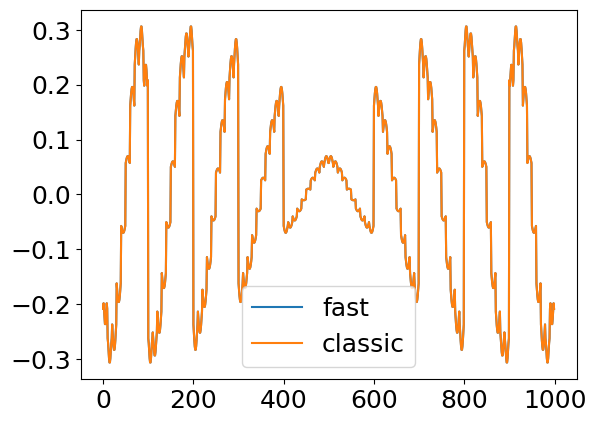

In [528]:
i = 2
j = 1

# Эффект, возникающий в таких тензорах, если i = 0 или j = 0, и не на главной диагонали, умножение отрицательно

if i == j:
    result = prep_fbbtmv_ifft(coeffs_EM[i][j], random_vec[..., j].reshape((n_1, n_2, n_3))).reshape(-1)
else:
    result = t_mult_3d(coeffs_EM[i][j], random_vec[..., j], n_1)
result_classic = B_matrix[:, :, i, j] @ random_vec[:, j]

plt.plot(result, label='fast')
plt.plot(result_classic, label="classic")
plt.legend()
plt.show()

In [529]:
result_fast = mult_toeplitz_3dEM(coeffs_EM, random_vec, n_1)

In [530]:
result_classic = np.einsum("ijkl,jl->ik", B_matrix, random_vec)

In [531]:
np.sum(np.abs(result_fast - result_classic))

5.279192787736462e-12

In [532]:
%%time
result_op_classic = operator_matrix(B_matrix, eta, random_vec)

CPU times: total: 156 ms
Wall time: 139 ms


In [533]:
%%time
result_op_fast = operator_3dEM(coeffs_EM, eta, random_vec, n_1)

CPU times: total: 109 ms
Wall time: 103 ms


In [534]:
np.sum(np.abs(result_op_fast - result_op_classic))

5.299660717750745e-12

In [537]:
result_EM, iters_EM, delta_EM, resid_EM = SIM_3dEM(coeffs_EM, f_wave, eta, n_1, mu)

Итерация=1, delta=0.9072374290597718, resid=3.4991140051258114
Итерация=2, delta=0.7223306037832815, resid=2.7859489159838695
Итерация=3, delta=0.5751102020808982, resid=2.21813617707281
Итерация=4, delta=0.4578952391123747, resid=1.766051082922178
Итерация=5, delta=0.3645702149660105, resid=1.4061068295664965
Итерация=6, delta=0.29026604840445724, resid=1.1195239114386748
Итерация=7, delta=0.23110604047616423, resid=0.8913503312329073
Итерация=8, delta=0.18400361405736598, resid=0.7096815037813822
Итерация=9, delta=0.1465012767144183, resid=0.5650391536992678
Итерация=10, delta=0.11664240503593182, resid=0.449876801793521
Итерация=11, delta=0.09286916099091823, resid=0.3581860397937751
Итерация=12, delta=0.07394121426508864, resid=0.28518305143022726
Итерация=13, delta=0.05887103004548947, resid=0.2270590246059865
Итерация=14, delta=0.04687234599896614, resid=0.1807814328252098
Итерация=15, delta=0.03731915031466526, resid=0.14393581805897612
Итерация=16, delta=0.029713020556711624, r